<a href="https://colab.research.google.com/github/pantherer/nlp_deep_learning/blob/main/Lstm_Bert_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

ALL_FILES = [
    # 2013
    "twitter-2013train-A.txt", "twitter-2013dev-A.txt", "twitter-2013test-A.txt",
    # 2014
    "twitter-2014sarcasm-A.txt", "twitter-2014test-A.txt",
    # 2015
    "twitter-2015train-A.txt", "twitter-2015train-BD.txt",
    "twitter-2015test-A.txt", "twitter-2015testBD.txt",
    # 2016 Subtask A
    "twitter-2016train-A.txt", "twitter-2016dev-A.txt", "twitter-2016devtest-A.txt", "twitter-2016test-A.txt",
    # 2016 Subtask BD
    "twitter-2016train-BD.txt", "twitter-2016dev-BD.txt", "twitter-2016devtest-BD.txt", "twitter-2016test-BD.txt",
    # 2016 Subtask CE (Numeric Labels)
    "twitter-2016train-CE.txt", "twitter-2016dev-CE.txt", "twitter-2016devtest-CE.txt", "twitter-2016test-CE.txt",
    # Cross-Domain
    "sms-2013test-A.tsv", "livejournal-2014test-A.tsv"
]

print(f"{'Filename':<30} | {'Rows':<6} | {'Columns':<8} | {'Status'}")
print("-" * 65)

total_rows = 0

for path in ALL_FILES:
    if not os.path.exists(path):
        print(f"{path:<30} | {'-':<6} | {'-':<8} | MISSING")
        continue

    try:
        # Read with quoting=3 to avoid errors with quotes in tweets
        df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')

        # Check column count to identify format
        col_count = df.shape[1]
        row_count = len(df)
        total_rows += row_count

        status = "OK"
        if col_count == 3:
            fmt = "Standard (A)"
        elif col_count >= 4:
            fmt = "Topic/Score (BD/CE)"
        else:
            fmt = "Unknown"
            status = "CHECK"

        print(f"{path:<30} | {row_count:<6} | {col_count:<8} | {status} ({fmt})")

    except Exception as e:
        print(f"{path:<30} | {'-':<6} | {'-':<8} |  ERROR")

print("-" * 65)
print(f"Total Raw Data Available: {total_rows:,} rows")

Filename                       | Rows   | Columns  | Status
-----------------------------------------------------------------
twitter-2013train-A.txt        | 9684   | 4        | OK (Topic/Score (BD/CE))
twitter-2013dev-A.txt          | 1654   | 3        | OK (Standard (A))
twitter-2013test-A.txt         | 3547   | 3        | OK (Standard (A))
twitter-2014sarcasm-A.txt      | 86     | 3        | OK (Standard (A))
twitter-2014test-A.txt         | 1853   | 3        | OK (Standard (A))
twitter-2015train-A.txt        | 489    | 3        | OK (Standard (A))
twitter-2015train-BD.txt       | 489    | 4        | OK (Topic/Score (BD/CE))
twitter-2015test-A.txt         | 2390   | 3        | OK (Standard (A))
twitter-2015testBD.txt         | 2383   | 5        | OK (Topic/Score (BD/CE))
twitter-2016train-A.txt        | 6000   | 3        | OK (Standard (A))
twitter-2016dev-A.txt          | 1999   | 3        | OK (Standard (A))
twitter-2016devtest-A.txt      | 2000   | 3        | OK (Standard (A))
t

In [ ]:
import pandas as pd
import numpy as np
import re
import os

# 1. FILE CONFIGURATION (Rebalanced 70/30)

# TRAIN FILES (Targeting ~70% of data)
# We move '2016test-A' and '2016test-BD' here to boost training size.
TRAIN_FILES = [
    # 2013
    "twitter-2013train-A.txt", "twitter-2013dev-A.txt",
    # 2014
    "twitter-2014sarcasm-A.txt",
    # 2015
    "twitter-2015train-A.txt", "twitter-2015train-BD.txt",
    # 2016 Standard Training
    "twitter-2016train-A.txt", "twitter-2016dev-A.txt", "twitter-2016devtest-A.txt",
    "twitter-2016train-BD.txt", "twitter-2016dev-BD.txt", "twitter-2016devtest-BD.txt",
    "twitter-2016train-CE.txt", "twitter-2016dev-CE.txt", "twitter-2016devtest-CE.txt",
    # MOVED FROM TEST TO TRAIN (To fix split)
    "twitter-2016test-A.txt",   # +20k rows
    "twitter-2016test-BD.txt"   # +10k rows
]

# TEST FILES (Targeting ~30% of data)
TEST_FILES = [
    "twitter-2013test-A.txt",
    "twitter-2014test-A.txt",
    "twitter-2015test-A.txt", "twitter-2015testBD.txt",
    "twitter-2016test-CE.txt",
    "sms-2013test-A.tsv",
    "livejournal-2014test-A.tsv"
]

# Standard Label Map
TEXT_LABEL_MAP = {
    "positive": "positive", "negative": "negative", "neutral": "neutral",
    "objective-or-neutral": "neutral", "objective": "neutral",
    "sarcasm": "negative", "sarcastic": "negative", "not-sarcastic": "neutral"
}

def map_sentiment(value):
    if pd.isna(value): return None
    # Text mapping
    if isinstance(value, str):
        value = value.strip().lower()
        if value in TEXT_LABEL_MAP: return TEXT_LABEL_MAP[value]
        try: return map_sentiment(int(value))
        except: return None
    # Numeric mapping
    if isinstance(value, (int, float)):
        if value > 0: return "positive"
        if value < 0: return "negative"
        return "neutral"
    return None

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "url", text)
    text = re.sub(r'\@\w+', 'user', text)
    return text

def load_universal_data(file_list):
    dfs = []
    print(f"{'File Name':<30} | {'Status':<10} | {'Rows'}")
    print("-" * 55)

    for path in file_list:
        if not os.path.exists(path):
            print(f"{path:<30} | MISSING    | -")
            continue

        try:
            # Read without header
            df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')

            # CONTENT-BASED DETECTION
            # Check if Column 1 contains sentiment words
            col1_sample = df.iloc[:, 1].astype(str).str.lower().head(10).tolist()
            col1_matches = sum(1 for x in col1_sample if x in TEXT_LABEL_MAP)

            # Decision Logic:
            if col1_matches > 0:
                # Format A (ID, Sentiment, Text)
                df = df.iloc[:, [0, 1, 2]]
                df.columns = ["ID", "Sentiment", "Text"]
            else:
                # Format B (ID, Topic, Sentiment, Text)
                # assuming sentiment is in Col 2 and Text in Col 3
                if df.shape[1] >= 4:
                    df = df.iloc[:, [0, 2, 3]]
                    df.columns = ["ID", "Sentiment", "Text"]
                else:
                    # Fallback for weird files (try standard)
                    df.columns = ["ID", "Sentiment", "Text"]

            # Apply Logic
            df['Sentiment'] = df['Sentiment'].apply(map_sentiment)
            df = df.dropna(subset=['Sentiment', 'Text'])
            df['Clean_Text'] = df['Text'].apply(clean_text)

            dfs.append(df)
            print(f"{path:<30} | LOADED     | {len(df)}")

        except Exception as e:
            print(f"{path:<30} | ERROR      | {str(e)[:10]}")

    if not dfs: return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

# --- EXECUTION ---
print("\n--- LOADING TRAINING DATA (70%) ---")
train_df = load_universal_data(TRAIN_FILES)

print("\n--- LOADING TEST DATA (30%) ---")
test_df = load_universal_data(TEST_FILES)

print("\n" + "="*40)
print(f"FINAL TRAINING SIZE: {len(train_df):,} samples")
print(f"FINAL TEST SIZE:     {len(test_df):,} samples")
print(f"SPLIT RATIO:         {len(train_df)/ (len(train_df)+len(test_df)):.1%} Train / {len(test_df)/ (len(train_df)+len(test_df)):.1%} Test")
print("="*40)


--- LOADING TRAINING DATA (70%) ---
File Name                      | Status     | Rows
-------------------------------------------------------
twitter-2013train-A.txt        | LOADED     | 9684
twitter-2013dev-A.txt          | LOADED     | 1654
twitter-2014sarcasm-A.txt      | LOADED     | 86
twitter-2015train-A.txt        | LOADED     | 489
twitter-2015train-BD.txt       | LOADED     | 486
twitter-2016train-A.txt        | LOADED     | 6000
twitter-2016dev-A.txt          | LOADED     | 1999
twitter-2016devtest-A.txt      | LOADED     | 2000
twitter-2016train-BD.txt       | LOADED     | 4346
twitter-2016dev-BD.txt         | LOADED     | 1325
twitter-2016devtest-BD.txt     | LOADED     | 1417
twitter-2016train-CE.txt       | LOADED     | 6000
twitter-2016dev-CE.txt         | LOADED     | 2000
twitter-2016devtest-CE.txt     | LOADED     | 2000
twitter-2016test-A.txt         | LOADED     | 20632
twitter-2016test-BD.txt        | LOADED     | 10551

--- LOADING TEST DATA (30%) ---
File Name

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# --- CONFIGURATION ---
MAX_VOCAB_SIZE = 20000
MAX_LEN = 100
EMBEDDING_DIM = 200
GLOVE_PATH = "glove.twitter.27B.200d.txt"

In [ ]:
# Download GloVe
if not os.path.exists(GLOVE_PATH):
    print("Downloading GloVe Embeddings...")
    !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
    !unzip -q glove.twitter.27B.zip
    print("Download Complete.")

--2025-11-27 21:36:29--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-11-27 21:36:29--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-11-27 21:36:29--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
# 2. Tokenization & Encoding
print("Tokenizing data...")
le = LabelEncoder()
# Fit on ALL labels to ensure we know all classes (positive, negative, neutral)
all_labels = pd.concat([train_df['Sentiment'], test_df['Sentiment']]).unique()
le.fit(all_labels)

Tokenizing data...


LabelEncoder()

In [ ]:
y_train = le.transform(train_df['Sentiment'])
y_test = le.transform(test_df['Sentiment'])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['Clean_Text'])

In [ ]:
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Clean_Text']), maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Clean_Text']), maxlen=MAX_LEN, padding='post')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# --- CONFIGURATION ---
MAX_VOCAB_SIZE = 20000
MAX_LEN = 100
EMBEDDING_DIM = 200

In [ ]:

GLOVE_TXT = "/content/glove.twitter.27B.200d.txt"

In [ ]:

# 1. TOKENIZATION

print("Tokenizing unified data...")
le = LabelEncoder()
all_labels = pd.concat([train_df['Sentiment'], test_df['Sentiment']]).unique()
le.fit(all_labels)

y_train = le.transform(train_df['Sentiment'])
y_test = le.transform(test_df['Sentiment'])

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['Clean_Text'])

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Clean_Text']), maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Clean_Text']), maxlen=MAX_LEN, padding='post')



Tokenizing unified data...


In [ ]:
# 2. EMBEDDING MATRIX

print(f"Loading embeddings from {GLOVE_TXT}...")
embeddings_index = {}
try:
    with open(GLOVE_TXT, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try: coefs = np.asarray(values[1:], dtype='float32')
            except: continue
            embeddings_index[word] = coefs
except FileNotFoundError:
    print(f"❌ Error: File not found at {GLOVE_TXT}. Please check file path.")

word_index = tokenizer.word_index
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
hits = 0
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
print(f"✅ GloVe Coverage: {hits} words found out of {num_words}")

Loading embeddings from /content/glove.twitter.27B.200d.txt...
✅ GloVe Coverage: 16915 words found out of 20000


In [ ]:
# 3. MODEL TRAINING

class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax')
])

optimizer = Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

print("\nStarting Training...")
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Class Weights: {0: np.float64(1.9920789288231149), 1: np.float64(1.0413019774261043), 2: np.float64(0.650332210627059)}

Starting Training...
Epoch 1/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.5018 - loss: 0.9491 - val_accuracy: 0.5326 - val_loss: 0.9827 - learning_rate: 0.0010
Epoch 2/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.6878 - loss: 0.7044 - val_accuracy: 0.5710 - val_loss: 0.9131 - learning_rate: 0.0010
Epoch 3/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.7328 - loss: 0.6104 - val_accuracy: 0.6574 - val_loss: 0.7676 - learning_rate: 0.0010
Epoch 4/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.7579 - loss: 0.5467 - val_accuracy: 0.6642 - val_loss: 0.7994 - learning_rate: 0.0010
Epoch 5/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.7850 - loss: 0.4855 - val_accuracy: 0.6336 - val_loss: 0.9134 - learning_rate: 0.0010
Epoch 6/12
994/994 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8099 - loss: 0.4233 


Final Test Accuracy: 67.45%
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


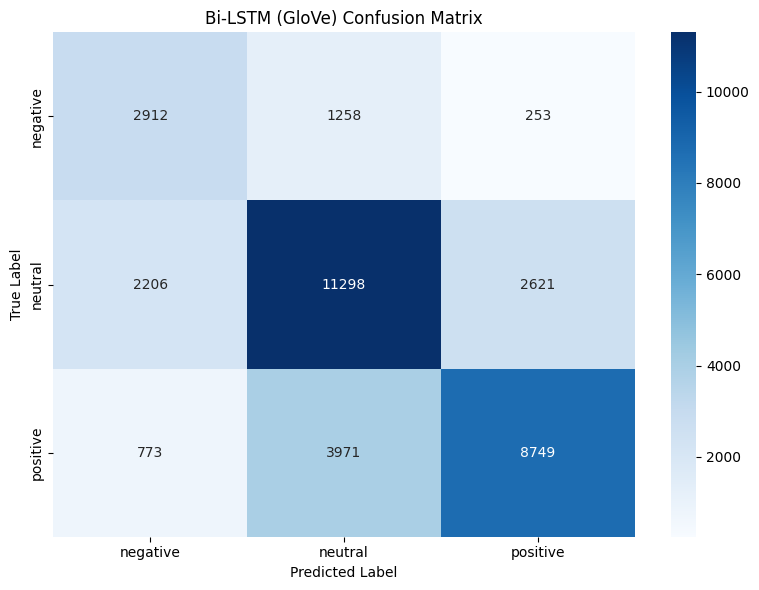

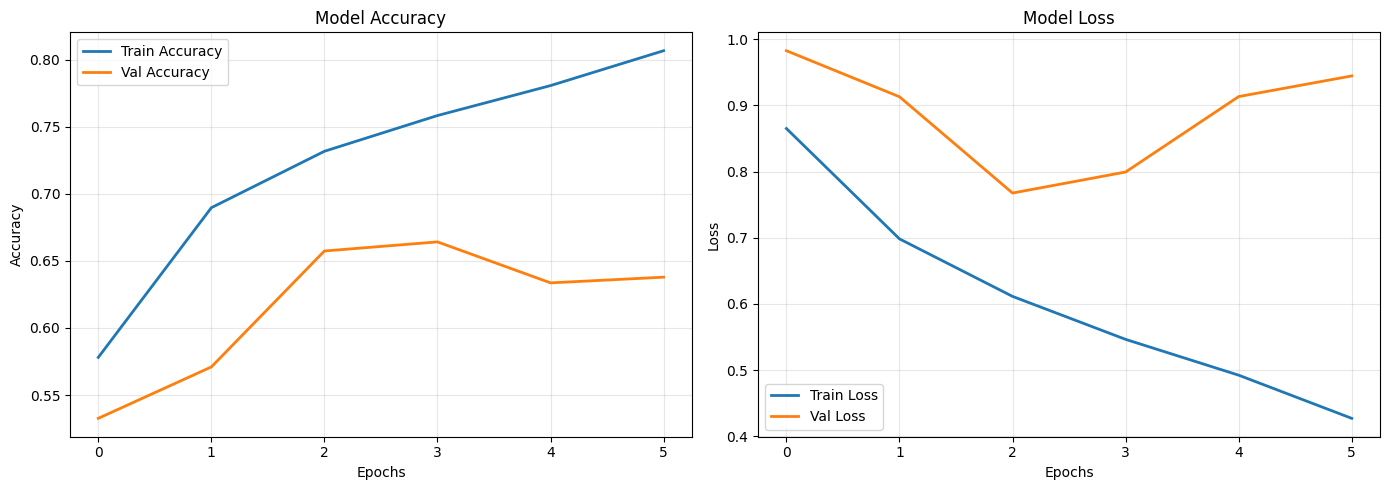


Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.66      0.56      4423
     neutral       0.68      0.70      0.69     16125
    positive       0.75      0.65      0.70     13493

    accuracy                           0.67     34041
   macro avg       0.64      0.67      0.65     34041
weighted avg       0.69      0.67      0.68     34041



In [ ]:

# 4. EVALUATION & IMAGES
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Bi-LSTM (GloVe) Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('lstm_glove_confusion_matrix.png', dpi=300)
plt.show()

# Image 2: Learning Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_glove_learning_curves.png', dpi=300)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [25]:
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from transformers import BertTokenizer, TFBertForSequenceClassification



In [26]:

TRAIN_FILES = [
    "twitter-2013train-A.txt", "twitter-2013dev-A.txt", "twitter-2014sarcasm-A.txt",
    "twitter-2015train-A.txt", "twitter-2015train-BD.txt",
    "twitter-2016train-A.txt", "twitter-2016dev-A.txt", "twitter-2016devtest-A.txt",
    "twitter-2016train-BD.txt", "twitter-2016dev-BD.txt", "twitter-2016devtest-BD.txt",
    "twitter-2016train-CE.txt", "twitter-2016dev-CE.txt", "twitter-2016devtest-CE.txt",
    "twitter-2016test-A.txt", "twitter-2016test-BD.txt" # Moving test sets to train
]

TEST_FILES = [
    "twitter-2013test-A.txt", "twitter-2014test-A.txt", "twitter-2015test-A.txt",
    "twitter-2015testBD.txt", "twitter-2016test-CE.txt", "sms-2013test-A.tsv", "livejournal-2014test-A.tsv"
]

TEXT_LABEL_MAP = {
    "positive": "positive", "negative": "negative", "neutral": "neutral",
    "objective-or-neutral": "neutral", "objective": "neutral",
    "sarcasm": "negative", "sarcastic": "negative", "not-sarcastic": "neutral"
}

def map_sentiment(value):
    if pd.isna(value): return None
    if isinstance(value, str):
        value = value.strip().lower()
        if value in TEXT_LABEL_MAP: return TEXT_LABEL_MAP[value]
        try: return map_sentiment(int(value))
        except: return None
    if isinstance(value, (int, float)):
        if value > 0: return "positive"
        if value < 0: return "negative"
        return "neutral"
    return None

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "url", text)
    text = re.sub(r'\@\w+', 'user', text)
    return text

def load_universal_data(file_list):
    dfs = []
    print(f"Loading files...")
    for path in file_list:
        if not os.path.exists(path): continue
        try:
            df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')
            if df.shape[1] == 3: df.columns = ["ID", "Sentiment", "Text"]
            elif df.shape[1] >= 4:
                df = df.rename(columns={0: "ID", 2: "Sentiment", 3: "Text"})
                df = df[["ID", "Sentiment", "Text"]]

            df['Sentiment'] = df['Sentiment'].apply(map_sentiment)
            df = df.dropna(subset=['Sentiment', 'Text'])
            df['Clean_Text'] = df['Text'].apply(clean_text)
            dfs.append(df)
        except: pass
    if not dfs: return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

In [28]:
# Load Data
print("Building Datasets...")
train_df = load_universal_data(TRAIN_FILES)
test_df = load_universal_data(TEST_FILES)
print(f"Train Size: {len(train_df)}")
print(f"Test Size:  {len(test_df)}")

Building Datasets...
Loading files...
Loading files...
Train Size: 40354
Test Size:  34041


In [29]:
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from transformers import BertTokenizer, TFBertForSequenceClassification



TRAIN_FILES = [
    "twitter-2013train-A.txt", "twitter-2013dev-A.txt", "twitter-2014sarcasm-A.txt",
    "twitter-2015train-A.txt", "twitter-2015train-BD.txt",
    "twitter-2016train-A.txt", "twitter-2016dev-A.txt", "twitter-2016devtest-A.txt",
    "twitter-2016train-BD.txt", "twitter-2016dev-BD.txt", "twitter-2016devtest-BD.txt",
    "twitter-2016train-CE.txt", "twitter-2016dev-CE.txt", "twitter-2016devtest-CE.txt",
    "twitter-2016test-A.txt", "twitter-2016test-BD.txt" # Moving test sets to train
]

TEST_FILES = [
    "twitter-2013test-A.txt", "twitter-2014test-A.txt", "twitter-2015test-A.txt",
    "twitter-2015testBD.txt", "twitter-2016test-CE.txt", "sms-2013test-A.tsv", "livejournal-2014test-A.tsv"
]

TEXT_LABEL_MAP = {
    "positive": "positive", "negative": "negative", "neutral": "neutral",
    "objective-or-neutral": "neutral", "objective": "neutral",
    "sarcasm": "negative", "sarcastic": "negative", "not-sarcastic": "neutral"
}

def map_sentiment(value):
    if pd.isna(value): return None
    if isinstance(value, str):
        value = value.strip().lower()
        if value in TEXT_LABEL_MAP: return TEXT_LABEL_MAP[value]
        try: return map_sentiment(int(value))
        except: return None
    if isinstance(value, (int, float)):
        if value > 0: return "positive"
        if value < 0: return "negative"
        return "neutral"
    return None

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "url", text)
    text = re.sub(r'\@\w+', 'user', text)
    return text

def load_universal_data(file_list):
    dfs = []
    print(f"Loading files...")
    for path in file_list:
        if not os.path.exists(path): continue
        try:
            # Read without header
            df = pd.read_csv(path, sep='\t', header=None, quoting=3, engine='python')

            # Check if Column 1 contains sentiment words
            col1_sample = df.iloc[:, 1].astype(str).str.lower().head(10).tolist()
            col1_matches = sum(1 for x in col1_sample if x in TEXT_LABEL_MAP)

            if col1_matches > 0:
                # Format A (ID, Sentiment, Text)
                df = df.iloc[:, [0, 1, 2]]
                df.columns = ["ID", "Sentiment", "Text"]
            else:
                # Format B (ID, Topic, Sentiment, Text)
                if df.shape[1] >= 4:
                    df = df.iloc[:, [0, 2, 3]]
                    df.columns = ["ID", "Sentiment", "Text"]
                else:
                    df.columns = ["ID", "Sentiment", "Text"] # Fallback

            df['Sentiment'] = df['Sentiment'].apply(map_sentiment)
            df = df.dropna(subset=['Sentiment', 'Text'])
            df['Clean_Text'] = df['Text'].apply(clean_text)
            dfs.append(df)
        except: pass
    if not dfs: return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

# Load Data
print("Building Datasets...")
train_df = load_universal_data(TRAIN_FILES)
test_df = load_universal_data(TEST_FILES)
print(f"Train Size: {len(train_df)}")
print(f"Test Size:  {len(test_df)}")




Building Datasets...
Loading files...
Loading files...
Train Size: 70669
Test Size:  34041


In [30]:
# 2. BERT PREPARATION

print("\nPreparing BERT...")
le = LabelEncoder()
all_labels = pd.concat([train_df['Sentiment'], test_df['Sentiment']]).unique()
le.fit(all_labels)
y_train = le.transform(train_df['Sentiment'])
y_test = le.transform(test_df['Sentiment'])

# Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(texts, max_len=80):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_len,
            padding='max_length', truncation=True, return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

print("Encoding Training Data (this takes a minute)...")
train_inputs, train_masks = bert_encode(train_df['Clean_Text'])
print("Encoding Test Data...")
test_inputs, test_masks = bert_encode(test_df['Clean_Text'])




Preparing BERT...
Encoding Training Data (this takes a minute)...
Encoding Test Data...


In [32]:
import tensorflow as tf
import tf_keras


# 3. TRAINING (solving Keras 3 Compatibility)
print("\nInitializing BERT Model...")
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_), from_pt=True)

#  Using 'tf_keras' explicitly for Optimizer and Loss
optimizer = tf_keras.optimizers.Adam(learning_rate=2e-5)
loss = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("Starting Training ")
history = model.fit(
    [train_inputs, train_masks],
    y_train,
    validation_split=0.1,
    batch_size=16,
    epochs=2,
    class_weight=class_weights_dict
)


Initializing BERT Model...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training (2 Epochs is enough for BERT)...
Epoch 1/2
3976/3976 [==============================] - 1235s 286ms/step - loss: 0.6896 - accuracy: 0.6815 - val_loss: 0.6571 - val_accuracy: 0.7146
Epoch 2/2
3976/3976 [==============================] - 1087s 273ms/step - loss: 0.4756 - accuracy: 0.7922 - val_loss: 0.6243 - val_accuracy: 0.7628



Predicting on Test Set...
1064/1064 [==============================] - 193s 173ms/step


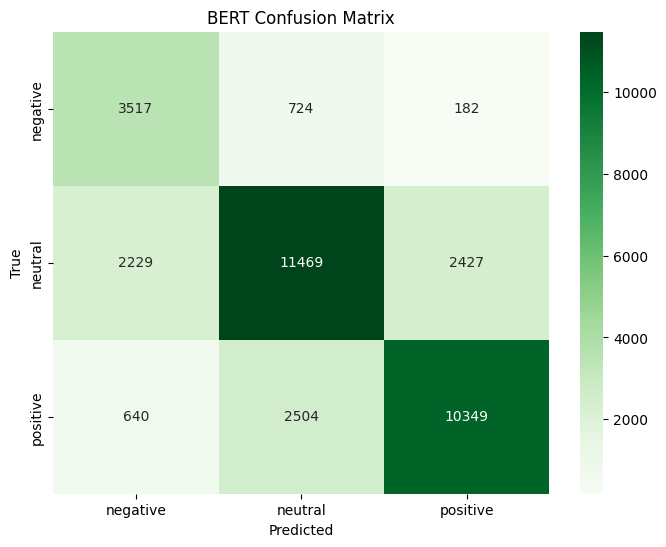

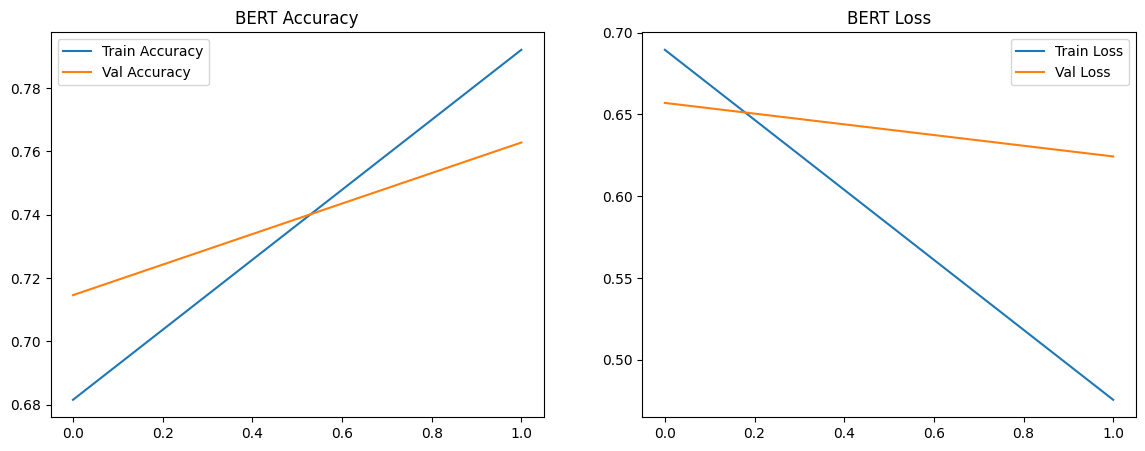


=== BERT Classification Report ===
              precision    recall  f1-score   support

    negative       0.55      0.80      0.65      4423
     neutral       0.78      0.71      0.74     16125
    positive       0.80      0.77      0.78     13493

    accuracy                           0.74     34041
   macro avg       0.71      0.76      0.73     34041
weighted avg       0.76      0.74      0.75     34041



In [33]:
# ==========================================
# 4. EVALUATION & VISUALIZATION
# ==========================================
print("\nPredicting on Test Set...")
preds = model.predict([test_inputs, test_masks])
y_pred = np.argmax(preds.logits, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('bert_confusion_matrix.png')
plt.show()

# Learning Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('BERT Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BERT Loss')
plt.legend()
plt.savefig('bert_learning_curves.png')
plt.show()

print("\n=== BERT Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))